In [1]:
# install and import libraries
%%capture
!pip install ir_datasets
!pip install demoji

import re
import html
import string
import datetime as dt

import numpy as np
import pandas as pd
import ir_datasets
import demoji

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet as wn


from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from collections import Counter

pd.set_option('max_colwidth', 800)

In [2]:
# load dataset
dataset = ir_datasets.load("cord19/trec-covid")
print(f"queries: {dataset.queries_count()}, docs: {dataset.docs_count()}, qrels: {dataset.qrels_count()}")

queries: 50, docs: 192509, qrels: 69318


# Part 1: Analysis of Queries and Documents

In [3]:
%%capture
# convert the collection in a dataframe
queries = pd.DataFrame(dataset.queries_iter())
docs = pd.DataFrame(dataset.docs_iter())
qrels = pd.DataFrame(dataset.qrels_iter())

docs['date'] = pd.to_datetime(docs['date'])

In [4]:
display(queries.sample(5))
display(docs.sample(5))
display(qrels.sample(5))

,query_id,title,description,narrative
20,21,coronavirus mortality,what are the mortality rates overall and in specific populations,"Seeking information on COVID-19 fatality rates in different countries and in different population groups based on gender, blood types, or other factors"
35,36,SARS-CoV-2 spike structure,What is the protein structure of the SARS-CoV-2 spike?,"Looking for studies of the structure of the spike protein on the virus using any methods, such as cryo-EM or crystallography"
27,28,coronavirus hydroxychloroquine,what evidence is there for the value of hydroxychloroquine in treating Covid-19?,Basic science or clinical studies assessing the benefit and harms of treating Covid-19 with hydroxychloroquine.
7,8,coronavirus under reporting,how has lack of testing availability led to underreporting of true incidence of Covid-19?,Looking for studies answering questions of impact of lack of complete testing for Covid-19 on incidence and prevalence of Covid-19.
2,3,coronavirus immunity,will SARS-CoV2 infected people develop immunity? Is cross protection possible?,seeking studies of immunity developed due to infection with SARS-CoV2 or cross protection gained due to infection with other coronavirus types


,doc_id,title,doi,date,abstract
13187,pkqwphdt,"Abstracts presented at the 13th International Congress on Amino acids, peptides and proteins",10.1007/s00726-013-1540-y,2013-08-14,
150003,ley91488,Application of the use of high‐throughput technologies to the determination of protein structures of bacterial and viral pathogens,10.1107/s0907444906030915,2006-10-04,"The Structural Proteomics In Europe (SPINE) programme is aimed at the development and implementation of high‐throughput technologies for the efficient structure determination of proteins of biomedical importance, such as those of bacterial and viral pathogens linked to human health. Despite the challenging nature of some of these targets, 175 novel pathogen protein structures (∼220 including complexes) have been determined to date. Here the impact of several technologies on the structural determination of proteins from human pathogens is illustrated with selected examples, including the parallel expression of multiple constructs, the use of standardized refolding protocols and optimized crystallization screens."
34295,0hd1vmxs,Dental Care and Oral Health under the Clouds of COVID-19.,10.1177/2380084420924385,2020-04-24,KNOWLEDGE TRANSFER STATEMENT This commentary provides a timely evidence-based overview on the impact of COVID-19 on dental care and oral health and identifies gaps in protection of patients and staff in dental settings. Oral symptoms are prominent before fever and cough occur. Dental professionals may play an important role in early identification and diagnosis of patients with COVID-19.
187445,4jx0u7js,“Diseases and Natural Kinds”,10.1007/s11017-005-2206-x,2005-01-01,"David Thomasma called for the development of a medical ethics based squarely on the philosophy of medicine. He recognized, however, that widespread anti-essentialism presented a significant barrier to such an approach. The aim of this article is to introduce a theory that challenges these anti-essentialist objections. The notion of natural kinds presents a modest form of essentialism that can serve as the basis for a foundationalist philosophy of medicine. The notion of a natural kind is neither static nor reductionistic. Disease can be understood as making necessary reference to living natural kinds without invoking the claim that diseases themselves are natural kinds. The idea that natural kinds have a natural disposition to flourish as the kinds of things that they are provides a te..."
31183,w64d30ux,Development of an ex vivo human-porcine respiratory model for preclinical studies.,10.1038/srep43121,2017-01-01,"Anatomical models to study aerosol delivery impose huge limitations and extrapolation to humans remains controversial. This study aimed to develop and validate an ex vivo human-like respiratory tract model easy to use and relevant to compare to in vivo human data. A human plastinated head is connected to an ex vivo porcine pulmonary tract ventilated artificially by passive expansion. A physiological study measures ""pleural"" depressions, tidal volumes, and minute ventilation for the respiratory rates chosen (10, 15, and 20 per minute) with three inspiratory/expiratory ratios (1/1, 1/2, and 1/3). Scintigraphy with 81mKrypton assesses the homogeneity of the ventilation. Forty different experiments were set for validation, with 36 (90%) ventilating successfully. At a respiratory rate of 15..."


,query_id,doc_id,relevance,iteration
68461,50,12540n1s,0,5
44073,29,zigt1qz7,2,5
33877,22,lnow1np4,1,4
36531,24,msr78qwy,2,5
26101,17,0bk2t0h0,2,4


* numbers
* punctuation
* symbols
* whitespaces
* stop words
* HTML tags
* repeated characters
* URLs
* emojis

---

- stemming / lemmatization ?

## Preprocessing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  


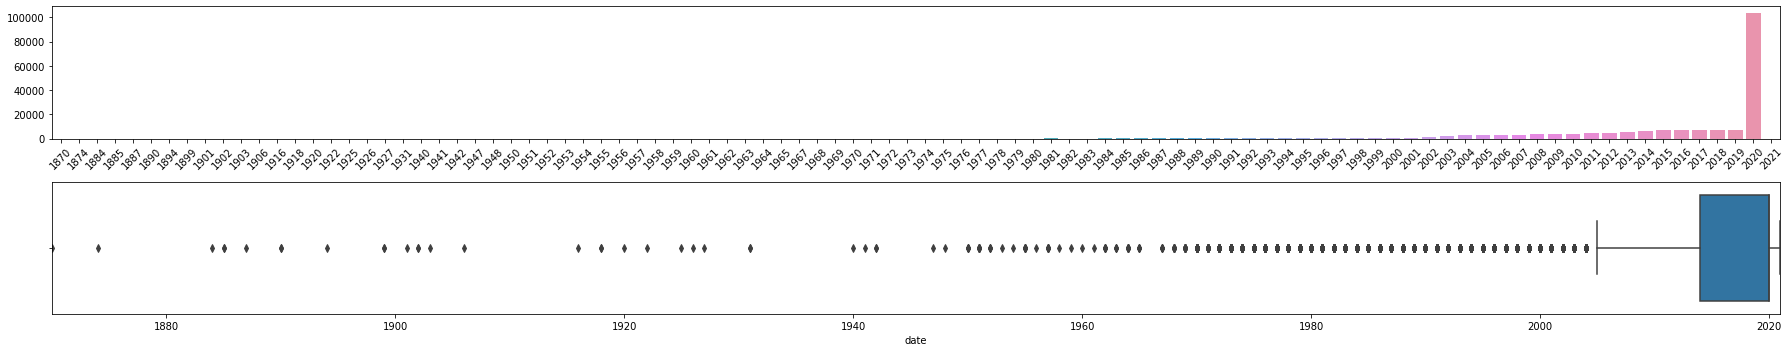

In [5]:
years = docs["date"].dt.year
years.dropna(inplace=True)
years = years.astype(int)

u_years, u_counts = np.unique(years, return_counts=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 5))

sns.barplot(x=u_years, y=u_counts, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)

sns.boxplot(x=years, ax=ax2, orient="h")
ax2.margins(0)

fig.tight_layout()

In [6]:
emojis = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  e1 = demoji.findall(row["title"])
  if e1:
    for e in list(e1.keys()):
      emojis.add(e)
    # print(index, e1)

  e2 = demoji.findall(row["abstract"])
  if e2:
    for e in list(e2.keys()):
      emojis.add(e)
    # print(index, e2)

  0%|          | 0/192509 [00:00<?, ?it/s]

In [7]:
emojis

{'©', '®', '™', '▪', '▶', '♀', '♂', '♦', '⬇'}

In [8]:
docs["abstract"][70663]

'Coronavirus EndoU inhibits dsRNA-activated antiviral responses; however, the physiologic RNA substrates of EndoU are unknown. In this study, we used mouse hepatitis virus (MHV)-infected bone-marrow-derived macrophage (BMM) and cyclic phosphate cDNA sequencing to identify the RNA targets of EndoU. EndoU targeted viral RNA, cleaving the 3′ side of pyrimidines with a strong preference for U⬇A and C⬇A sequences (endoY⬇A). EndoU-dependent cleavage was detected in every region of MHV RNA, from the 5′ NTR to the 3′ NTR, including transcriptional regulatory sequences (TRS). Cleavage at two CA dinucleotides immediately adjacent to the MHV poly(A) tail suggest a mechanism to suppress negative-strand RNA synthesis and the accumulation of viral dsRNA. MHV with EndoU (EndoUmut) or 2′-5′ phosphodiesterase (PDEmut) mutations provoked the activation of RNase L in BMM, with corresponding cleavage of RNAs by RNase L. The physiologic targets of EndoU are viral RNA templates required for negative-strand 

In [9]:
keywords = ["covid 19", "covid-19", "covid19", "sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

keep = set()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  text = " ".join([row["title"], row["abstract"]])
  if any(re.findall(r'|'.join(keywords), text, re.IGNORECASE)):
    keep.add(index)

  # the few documents without date contain at least one keyword
  if row["date"] and row["date"] is not pd.NaT:
    if row["date"].year >= 2019:         
        if any(re.findall(r'coronavirus', " ".join([row["title"], row["abstract"]]), re.IGNORECASE)):
          keep.add(index)

print(f"{len(keep)}, {round(len(keep) / len(docs) * 100)}%")

docs = docs.iloc[list(keep)]

  0%|          | 0/192509 [00:00<?, ?it/s]

84048, 44%


In [10]:
def remove_urls(text):
    regex = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
    return re.sub(regex, '', text)

def remove_doi(text):
    regex = r"\b(doi:\s+)?(10[.][0-9]{4,}(?:[.][0-9]+)*(?:(?![\"&\'<>])\S)+)\b"
    return re.sub(regex, "", text)

# decidere se tenere qualche carattere
def remove_punctuation(text):
    punctuation = string.punctuation + '“”'
    return "".join([i for i in text if i not in punctuation])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def replace_html_entities(text):
    return html.unescape(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def remove_emojis(text):
    return demoji.replace(text)

def remove_numbers(text):
    pass


# il lemmatizer di wordnet ha solo questi 4 tag 
def pos2wordnet(nltk_pos):
  if nltk_pos.startswith('J'):
    return wn.ADJ
  elif nltk_pos.startswith('V'):
    return wn.VERB
  elif nltk_pos.startswith('N'):
    return wn.NOUN
  elif nltk_pos.startswith('R'):
    return wn.ADV
  else:
    return wn.NOUN


def preprocess(text):
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    sent = sent.lower()
    sent = remove_urls(sent)
    sent = remove_doi(sent)
    sent = remove_extra_whitespace(sent)
    sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    sent = remove_emojis(sent)
    sent = remove_punctuation(sent)
    sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      t = wnl.lemmatize(token, pos2wordnet(pos))
      result.append(t)
    
  return result

In [11]:
text = docs["title"][4582]
x = preprocess(text)
text, x

('Therapeutic strategies in an outbreak scenario to treat the novel coronavirus originating in Wuhan, China',
 ['therapeutic',
  'strategy',
  'outbreak',
  'scenario',
  'treat',
  'novel',
  'coronavirus',
  'originate',
  'wuhan',
  'china'])

In [12]:
# global lists of tokens for wordclouds
titles = []
abstracts = []

docs_preprocessed = docs.copy()
for index, row in tqdm(docs.iterrows(), total=len(docs)):
  title_tokens = preprocess(row["title"])
  abstract_tokens = preprocess(row["abstract"])

  docs_preprocessed.loc[index, "title"] = ' '.join(title_tokens)
  docs_preprocessed.loc[index, "abstract"] = ' '.join(abstract_tokens)

  titles.extend(title_tokens)
  abstracts.extend(abstract_tokens)

  0%|          | 0/84048 [00:00<?, ?it/s]

In [ ]:
np.save("data/docs_processed", docs_preprocessed)

## Word Cloud

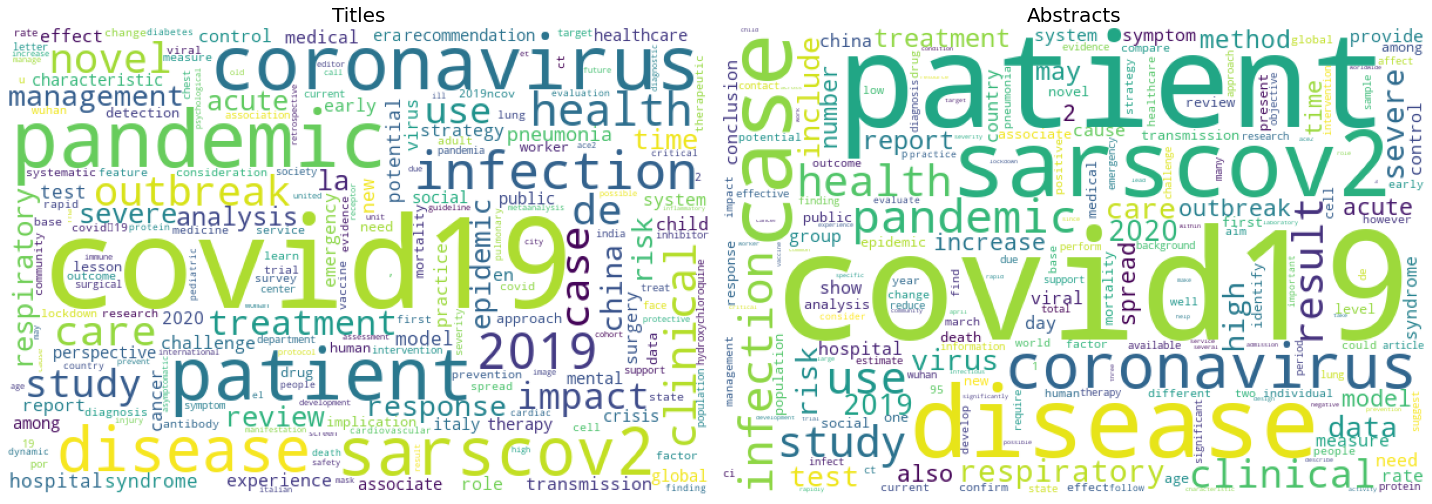

In [14]:
counter_title = Counter(titles)
counter_abstract = Counter(abstracts)

wc1 = WordCloud(collocations=False, background_color="white", width=600, height=400)
wc2 = WordCloud(collocations=False, background_color="white", width=600, height=400)

wc_titles = wc1.fit_words(counter_title)
wc_abstracts = wc2.fit_words(counter_abstract)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.imshow(wc_titles)
ax1.set_title("Titles", fontsize=20)
ax1.axis("off")

ax2.imshow(wc_abstracts)
ax2.set_title("Abstracts", fontsize=20)
ax2.axis("off")

fig.tight_layout()

## Token Statistics

In [15]:
print("\n[Number of Tokens]")
print("Titles:", len(counter_title.keys()))
print("Abstracts:", len(counter_abstract.keys()))

k = 10
top_k_titles = [word for word, count in counter_title.most_common(k)]
top_k_abstracts = [word for word, count in counter_abstract.most_common(k)]

print(f"\n[Top {k} Most Common Tokens]")
print(f"Titles: {', '.join(top_k_titles)}")
print(f"Abstracts: {', '.join(top_k_abstracts)}")


[Number of Tokens]
Titles: 29896
Abstracts: 116349

[Top 10 Most Common Tokens]
Titles: covid19, pandemic, coronavirus, patient, sarscov2, disease, infection, 2019, health, clinical
Abstracts: covid19, patient, disease, sarscov2, case, coronavirus, pandemic, infection, use, study


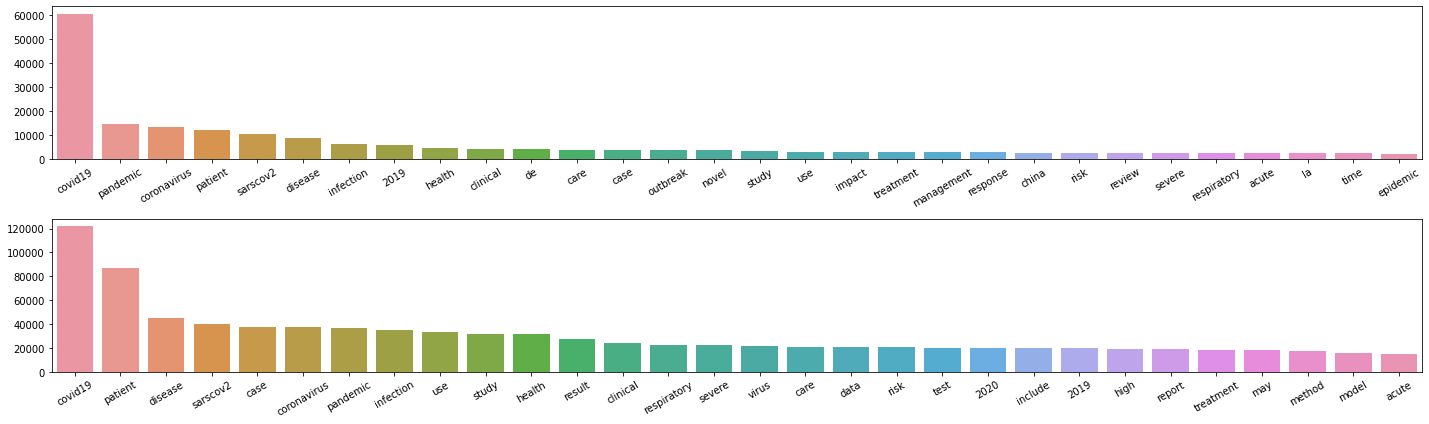

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

k = 30

common_titles = dict(counter_title.most_common(k))
x_title = list(common_titles.keys())
y_title = list(common_titles.values())

common_abstracts = dict(counter_abstract.most_common(k))
x_abstract = list(common_abstracts.keys())
y_abstract = list(common_abstracts.values())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
sns.barplot(x=x_title, y=y_title, ax=ax1)
sns.barplot(x=x_abstract, y=y_abstract, ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 30)
fig.tight_layout()

# Part 2: Basic Search

## Preprocessing of the query
Eliminate stopwords, remove punctuation. 
You can also perform any other pre-processing step.


* Lowcase
* Remove punctuation
* Remove extra whitespaces
* Normalize covid words
* Stop words
* Lemmatization
* Remove HTML tags
* Remove URLs
* Remove emojis



In [19]:
def covid_norm(text, mode="specific"):
  keywords_all = ["covid 19", "covid-19","sars-cov-2", "sarscov2", 
            "sars cov 2", "2019-nCoV", "Wuhan virus", "Chinese flu",
            "COronaVIrusDisease"]

  keywords_specific = ["covid 19", "covid-19"]

  if mode == "all":  
    keywords = keywords_all
  else:
    keywords = keywords_specific

  for key in keywords:
    text = text.replace(key, 'covid19')

  return text

In [20]:
# decidere se tenere qualche carattere
def remove_punctuation_query(text):
    punctuation = string.punctuation
    punctuation = punctuation.replace('+', '')
    punctuation = punctuation.replace('-', '') 
    punctuation = punctuation.replace('"', '')
    punctuation = punctuation.replace('{', '')
    punctuation = punctuation.replace('}', '')
    punctuation = punctuation.replace('(', '')
    punctuation = punctuation.replace(')', '')
    punctuation = punctuation.replace('.', '')
    punctuation = punctuation.replace(':', '')
    punctuation = punctuation.replace('~', '')
    punctuation = punctuation.replace('^', '')
    #print(punctuation)
    text = "".join([i for i in text if i not in punctuation])
    return text

In [21]:
def preprocessing_query(text, lower=True, URLs_remove=True, doi_remove=True, 
                        extra_whitespace_remove=True,
                        covid_normalization=False, html_remove=True, 
                        emoji_remove=True, punctuation_remove=True,
                        stop_words=True, lemmatization=True ):
  
  sentences = nltk.sent_tokenize(text)
  
  tokens_list = []
  for sent in sentences:
    if lower:
      sent = sent.lower()
    if URLs_remove:
      sent = remove_urls(sent)
    if doi_remove:
      sent = remove_doi(sent)
    if extra_whitespace_remove:
      sent = remove_extra_whitespace(sent)
    if covid_normalization:
      # Since it's a collection of scientific
      # papers we think it's better not to 
      # normalize the word by default.
      sent = covid_norm(sent)
    if html_remove:
      sent = replace_html_entities(sent) # before removing punctuation (&\w+;)
    if emoji_remove:
      sent = remove_emojis(sent)
    if punctuation_remove:
      sent = remove_punctuation_query(sent)
    if stop_words:
      sent = remove_stopwords(sent)

    tokens = nltk.word_tokenize(sent)
    tokens_list.append(tokens)

  tagged_tokens = nltk.pos_tag_sents(tokens_list)

  wnl = WordNetLemmatizer()

  result = []
  for tokens in tagged_tokens:
    for (token, pos) in tokens:
      if lemmatization:
        t = wnl.lemmatize(token, pos2wordnet(pos))
      else:
        t = token
      if t == 'covid' and covid_normalization:
        t = 'covid19'
      result.append(t)

  text = ' '.join(result)
  text = text.replace("``", '"')
  text = text.replace("''", '"')

  return text

In [22]:
test_query_old = [ 'CoVid', 'covid    19', 'covid-19  influenza', 'covid, influenza', 'a covid flue is going on',
               '-term1 +term2', '{term1 term2}', 'term1^2.3', 'title:term1',
               '+title:term1', 'title:(term1 term2)^2.3', 'term1 -title:term2', 
               '"term1 term2"', '+"term1 term2"', '"term1 term2"~n']

check_query_old = ['covid19', 'covid19', 'covid19 influenza', 'covid19 influenza', 'covid19 flue go', 
               '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', 
               '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', 
               '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']

In [29]:
test_query = [ 'CoVid', 'covid    19', 'covid-19  influenza', 'covid, influenza', 'a covid flue is going on',
               '-term1 +term2', '{term1 term2}', 'term1^2.3', 'title:term1',
               '+title:term1', 'title:(term1 term2)^2.3', 'term1 -title:term2', 
               '"term1 term2"', '+"term1 term2"', '"term1 term2"~n']

check_query = ['covid', 'covid 19', 'covid-19 influenza', 'covid influenza', 'covid flue go', 
               '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', 
               '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', 
               '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']

In [24]:
preprocessed_query = []
for query in test_query_old:
  preprocessed_query.append( preprocessing_query(query, covid_normalization=False) )
print( preprocessed_query )

['covid', 'covid 19', 'covid-19 influenza', 'covid influenza', 'covid flue go', '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']


In [30]:
assert check_query == preprocessed_query

In [27]:
preprocessed_query_old = []
for query in test_query_old:
  preprocessed_query_old.append( preprocessing_query(query, covid_normalization=True) )
print( preprocessed_query_old )

['covid19', 'covid19', 'covid19 influenza', 'covid19 influenza', 'covid19 flue go', '-term1 +term2', '{ term1 term2 }', 'term1^2.3', 'title : term1', '+title : term1', 'title : ( term1 term2 ) ^2.3', 'term1 -title : term2', '" term1 term2 "', '+ " term1 term2 "', '" term1 term2 " ~n']


In [28]:
  assert check_query_old == preprocessed_query_old

## Index the documents

Use PyTerrier to index the documents.

You can choose freely the indexing configurations.
You can index either the document’s titles, abstract, or both.

### Libraries

In [31]:
!pip install python-terrier

     |████████████████████████████████| 95 kB 2.4 MB/s 
     |████████████████████████████████| 1.1 MB 31.2 MB/s 
     |████████████████████████████████| 69 kB 6.0 MB/s 
     |████████████████████████████████| 41 kB 302 kB/s 
     |████████████████████████████████| 291 kB 40.2 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.7.2-py3-none-any.whl size=101953 sha256=641811058ff4faac19c0b5e988a4e86e61c6f2a6130f6e26bde4803bcd7010f1
  Stored in directory: /root/.cache/pip/wheels/ea/0c/14/089e998b6dee036ccf45723f3b142b84cbadb7f683e6facb47
  Created wheel for ir-measures: filename=ir_measures-0.2.3-py3-none-any.whl size=53217 sha256=885c0a54701eb8359392889be417534795c42bc32329a07171f6f5a7c77e8a64
  Stored in directory: /root/.cache/pip/wheels/b2/06/1b/b8dc2d9a9802a9c30dd3a28d4199061297df0034d8ab9b808a
  Created wheel for cwl-eval: filename=cwl_eval-1.0.10-py3-none

In [32]:
import pyterrier as pt

### Data

In [33]:
print( type(docs_preprocessed) )
docs_df = pd.DataFrame(docs_preprocessed, columns = ['id','title','doi','date', 'abstract'])
print( type( docs_df ))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [34]:
print("The dataset has the type {} for the column ID" .format( type( docs_df.iloc[0,0] )) )
print("The dataset has the type {} for the column TITLE" .format( type( docs_df.iloc[0,1] )) )
print("The dataset has the type {} for the column DATE" .format( type( docs_df.iloc[0,2] )) )
print("The dataset has the type {} for the column ABSTRACT" .format( type( docs_df.iloc[0,3] )) )
print("The dataset has the type {} for the column DOI" .format( type( docs_df.iloc[0,4] )) )

The dataset has the type <class 'numpy.float64'> for the column ID
The dataset has the type <class 'str'> for the column TITLE
The dataset has the type <class 'str'> for the column DATE
The dataset has the type <class 'pandas._libs.tslibs.timestamps.Timestamp'> for the column ABSTRACT
The dataset has the type <class 'str'> for the column DOI


In [35]:
print("The dataset has {} rows of ID empty" .format(len( docs_df[docs_df['id'] == '' ] )) )
print("The dataset has {} rows of TITLE empty" .format(len( docs_df[docs_df['title'] == '' ] )) )
print("The dataset has {} rows of DATE empty" .format(len( docs_df[docs_df['date'].isnull() ] )) )
print("The dataset has {} rows of ABSTRACT empty" .format(len( docs_df[docs_df['abstract'] == '' ] )) )
print("The dataset has {} rows of DOI empty" .format(len( docs_df[docs_df['doi'] == '' ] )) )

The dataset has 0 rows of ID empty
The dataset has 8 rows of TITLE empty
The dataset has 17 rows of DATE empty
The dataset has 34043 rows of ABSTRACT empty
The dataset has 40903 rows of DOI empty


In [36]:
docs_df["title"].replace({"": "Vuoto"}, inplace=True)
docs_df["abstract"].replace({"": "Vuoto"}, inplace=True)
docs_df["doi"].replace({"": "Vuoto"}, inplace=True)
docs_df["date"].fillna( pd.Timestamp(0, unit='s'), inplace = True)

In [37]:
print("The dataset has {} rows of ID empty" .format(len( docs_df[docs_df['id'] == '' ] )) )
print("The dataset has {} rows of TITLE empty" .format(len( docs_df[docs_df['title'] == '' ] )) )
print("The dataset has {} rows of DATE empty" .format(len( docs_df[docs_df['date'].isnull() ] )) )
print("The dataset has {} rows of ABSTRACT empty" .format(len( docs_df[docs_df['abstract'] == '' ] )) )
print("The dataset has {} rows of DOI empty" .format(len( docs_df[docs_df['doi'] == '' ] )) )

The dataset has 0 rows of ID empty
The dataset has 0 rows of TITLE empty
The dataset has 0 rows of DATE empty
The dataset has 0 rows of ABSTRACT empty
The dataset has 0 rows of DOI empty


In [38]:
np.where( pd.isnull(docs_df) )

(array([    0,     1,     2, ..., 84045, 84046, 84047]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [39]:
num_id = [str(i) for i in range(1, len(docs_df.index)+1)]
#print(num_id)
docs_df.insert(0, "docno", num_id, True)

### Index

In [40]:
if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done
PyTerrier 0.7.2 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


In [51]:
def create_index(docs_df, mode="both", indexer_path="./pd_index"):

  num_id = [str(i) for i in range(1, len(docs_df.index)+1)]
  #print(num_id)
  docs_df.insert(0, "docno", num_id, True)

  pd_indexer = pt.DFIndexer(indexer_path, remove_stopwords=False,  overwrite=True)

  if mode == 'title':
    index_ref = pd_indexer.index(docs_df['title'], docs_df['docno'])
  elif mode == 'abstract':
    index_ref = pd_indexer.index(docs_df['abstract'], docs_df['docno'])
  else: #both or else
    index_ref = pd_indexer.index(docs_df['title'], docs_df['abstract'], docs_df['docno'])

  return index_ref

In [42]:
# index the text, record the docnos as metadata
index_ref = create_index(docs_df, mode="both")

16:37:33.406 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (64215) - further warnings are suppressed
16:37:46.206 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 6 empty documents


In [43]:
!ls -lh pd_index/

total 33M
-rw-r--r-- 1 root root 1.3M Jan 12 16:37 data.direct.bf
-rw-r--r-- 1 root root 1.4M Jan 12 16:37 data.document.fsarrayfile
-rw-r--r-- 1 root root 1.2M Jan 12 16:37 data.inverted.bf
-rw-r--r-- 1 root root 2.0M Jan 12 16:37 data.lexicon.fsomapfile
-rw-r--r-- 1 root root 1017 Jan 12 16:37 data.lexicon.fsomaphash
-rw-r--r-- 1 root root  93K Jan 12 16:37 data.lexicon.fsomapid
-rw-r--r-- 1 root root 1.7M Jan 12 16:37 data.meta-0.fsomapfile
-rw-r--r-- 1 root root 657K Jan 12 16:37 data.meta.idx
-rw-r--r-- 1 root root  25M Jan 12 16:37 data.meta.zdata
-rw-r--r-- 1 root root 4.2K Jan 12 16:37 data.properties


In [44]:
index = pt.IndexFactory.of(index_ref)

In [45]:
print(index.getCollectionStatistics().toString())

i = 0
max = 10
for kv in index.getLexicon():
  i = i+1
  if i < max:
    print("%s -> %s" % (kv.getKey(), kv.getValue().toString()) ) 
  if i == max:
    print(".....")
    break

Number of documents: 84048
Number of terms: 23780
Number of postings: 730926
Number of fields: 0
Number of tokens: 755244
Field names: []
Positions:   false

0 -> term19327 Nt=5 TF=5 maxTF=1 @{0 0 0}
000 -> term3877 Nt=27 TF=27 maxTF=1 @{0 11 6}
002 -> term9283 Nt=4 TF=4 maxTF=1 @{0 75 0}
016 -> term9987 Nt=1 TF=1 maxTF=1 @{0 86 2}
019 -> term11919 Nt=1 TF=1 maxTF=1 @{0 89 6}
025 -> term17931 Nt=2 TF=2 maxTF=1 @{0 93 2}
03 -> term1335 Nt=4 TF=4 maxTF=1 @{0 101 0}
0354 -> term23230 Nt=1 TF=1 maxTF=1 @{0 110 4}
05 -> term1342 Nt=4 TF=4 maxTF=1 @{0 114 6}
.....


In [46]:
def index_model(index, model="TF_IDF"):
  """
    Create and return an indexing model.
    http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html
    Model can be such as:
    "TF_IDF", "PL2", "DLH", 
    "Hiemstra_LM", "Dirichlet_LM",
    "BM25", etc
  """
  list_model = ["TF_IDF", "PL2", "DLH", 
                "Hiemstra_LM", "Dirichlet_LM",
                "BM25"]
  
  indexing_model = pt.BatchRetrieve(index, wmodel=model)
  return indexing_model

In [47]:
def search_in_model(query, model, lower=True, URLs_remove=True, doi_remove=True, 
                        extra_whitespace_remove=True,
                        covid_normalization=False, html_remove=True, 
                        emoji_remove=True, punctuation_remove=True,
                        stop_words=True, lemmatization=True ):
  
  query = preprocessing_query(query, lower, URLs_remove, doi_remove, 
                        extra_whitespace_remove,
                        covid_normalization, html_remove, 
                        emoji_remove, punctuation_remove,
                        stop_words, lemmatization )
  return model.search(query)

In [48]:
tfidf = index_model(index, model="TF_IDF")

https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md

In [49]:
#A single query (that I manually provide) 
search_in_model("china", tfidf)

,qid,docid,docno,rank,score,query
0,1,31822,31823,0,3.959978,china
1,1,31823,31824,1,3.959978,china
2,1,75677,75678,2,3.959978,china
3,1,47911,47912,3,3.712163,china
4,1,76248,76249,4,3.712163,china
...,...,...,...,...,...,...
995,1,9671,9672,995,2.698815,china
996,1,9692,9693,996,2.698815,china
997,1,9992,9993,997,2.698815,china
998,1,10020,10021,998,2.698815,china


In [50]:
print("+woman covid")
retr = search_in_model("+woman covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("+woman covid")
retr = tfidf.search("+woman covid")
print( len(retr.index) )
display(retr.head(3))

print("+woman +covid")
retr = search_in_model("+woman +covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("+woman +covid")
retr = tfidf.search("+woman +covid")
print( len(retr.index) )
display(retr.head(3))

print("-woman +covid")
retr = search_in_model("-woman +covid", tfidf)
print( len(retr.index) )
display(retr.head(3))

print("-woman +covid")
retr = tfidf.search("-woman +covid")
print( len(retr.index) )
display(retr.head(3))

print('{woman covid}')
retr = search_in_model('{woman covid}', tfidf)
print( len(retr.index) )
display(retr.head(3))

print('{ woman term2 }')
retr = tfidf.search('{ woman covid }')
print( len(retr.index) )
display(retr.head(3))

+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman covid
1,1,81751,81752,1,7.489354,+woman covid
2,1,68732,68733,2,6.807871,+woman covid


+woman covid
620


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman covid
1,1,81751,81752,1,7.489354,+woman covid
2,1,68732,68733,2,6.807871,+woman covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman +covid
1,1,81751,81752,1,7.489354,+woman +covid
2,1,68732,68733,2,6.807871,+woman +covid


+woman +covid
15


,qid,docid,docno,rank,score,query
0,1,76668,76669,0,7.489354,+woman +covid
1,1,81751,81752,1,7.489354,+woman +covid
2,1,68732,68733,2,6.807871,+woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315673,-woman +covid
1,1,2078,2079,1,4.315673,-woman +covid
2,1,3440,3441,2,4.315673,-woman +covid


-woman +covid
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.315673,-woman +covid
1,1,2078,2079,1,4.315673,-woman +covid
2,1,3440,3441,2,4.315673,-woman +covid


{woman covid}
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.01839,{ woman covid }
1,1,2078,2079,1,4.01839,{ woman covid }
2,1,3440,3441,2,4.01839,{ woman covid }


{ woman term2 }
1000


,qid,docid,docno,rank,score,query
0,1,107,108,0,4.01839,{ woman covid }
1,1,2078,2079,1,4.01839,{ woman covid }
2,1,3440,3441,2,4.01839,{ woman covid }


To do indexing just choose the model to use through the function:

`index_ref = create_index(docs_df, mode="both")`

mode decide if indexing just title, abstract or both.

`index = pt.IndexFactory.of(index_ref)`

`tfidf = index_model(index, model="TF_IDF")`

and then use the function:

`search_in_model("your query", tfidf)`


To know more about the query look [here](https://github.com/terrier-org/terrier-core/blob/5.x/doc/querylanguage.md)

To know more about the model you can use look [here](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html). You can use model as "TF_IDF", "PL2", "DLH", "Hiemstra_LM", "Dirichlet_LM", etc.


# Part 3: Advanced Search (Optional)

# NOTE

prof: importate la precision. l'obiettivo é riportare la risposta migliore
